Clean an run the normalizing flow on all latent space

## Top of notebook

In [2]:
import numpy as np
from scipy.stats import norm

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import backend as K
tfk = tf.keras
tfkl = tfk.layers
tfd = tfp.distributions
tfb = tfp.bijectors

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import sys
sys.path.insert(0,'../')
from flow import *
import utils

## Test from latent space of VAE

In [3]:
z = np.load('../data/latent_space.npy',mmap_mode = 'c')
z_2 = np.load('../data/latent_space_2.npy',mmap_mode = 'c')

z = np.concatenate((z,z_2), axis = 0)

## Loading trained model

In [4]:
hidden_dim = [256,256]
layers =8
bijectors = []
for i in range(0, layers):
    made = make_network(32, hidden_dim,2)
    bijectors.append(MAF(made))
    bijectors.append(tfb.Permute(permutation=[31,30,29,28,27,26,25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0]))
    
bijectors = tfb.Chain(bijectors=list(reversed(bijectors[:-1])))

distribution = tfd.TransformedDistribution(
    distribution=tfd.Normal(loc=0., scale=1.),
    bijector=bijectors,
    event_shape=[32]
)

x_ = tfkl.Input(shape=(32,), dtype=tf.float32)
log_prob_ = distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)

model.compile(optimizer=tf.optimizers.Adam(), loss=lambda _, log_prob: -log_prob)

In [19]:
loading_path = '../nflow_weights/'
latest = tf.train.latest_checkpoint(loading_path)
model.load_weights(latest)

In [42]:
_ = model.fit(x=z_2,
              y=np.zeros((z_2.shape[0], 0), dtype=np.float32),
              batch_size= z_2.shape[0],
              epochs=5,
              steps_per_epoch=1,
              verbose=1, 
              shuffle=False)

Train on 50000 samples
Epoch 1/5
50000/50000 [==============================] - 4s 87us/sample - loss: 67.0953
Epoch 2/5
50000/50000 [==============================] - 2s 42us/sample - loss: 64.9264
Epoch 3/5
50000/50000 [==============================] - 2s 42us/sample - loss: 63.2004
Epoch 4/5
50000/50000 [==============================] - 2s 43us/sample - loss: 61.9531
Epoch 5/5
50000/50000 [==============================] - 2s 46us/sample - loss: 61.1189


In [20]:
samples = distribution.sample(100000)

In [21]:
samples.shape

TensorShape([100000, 32])

0
mu z: -0.0029954666276466417 sigma z: 1.606304417544382
1


/sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  from ipykernel import kernelapp as app


mu z: 0.14648211557320126 sigma z: 1.385527738249563
2
mu z: -0.002404891142242835 sigma z: 1.63748863033781
3
mu z: 0.0017612746283812263 sigma z: 1.6409900300761895
4
mu z: -0.01107336978452871 sigma z: 1.6214101027101977
5
mu z: 0.005062652777217738 sigma z: 1.6389593598966976
6
mu z: 0.0036206782367795153 sigma z: 1.6127996757595864
7
mu z: -0.012937840779428594 sigma z: 1.5923759133557371
8
mu z: -0.2628355604053044 sigma z: 1.3935570964900355
9
mu z: -0.3639379501353491 sigma z: 1.292894280730144
10
mu z: 0.0006179998783362072 sigma z: 1.6406086378176636
11
mu z: 0.009439240848067139 sigma z: 1.6396325396398876
12
mu z: -0.0020976788932949644 sigma z: 1.6431210678797197
13
mu z: 0.012493922827994379 sigma z: 1.4664864614579594
14
mu z: 0.0361170625615555 sigma z: 1.437677428087942
15
mu z: -0.01153981047163277 sigma z: 1.4397340373262155
16
mu z: 0.2188021009383845 sigma z: 1.3768920782892446
17
mu z: 0.004518779483631604 sigma z: 1.625751993824459
18
mu z: -0.3853179512702115 si

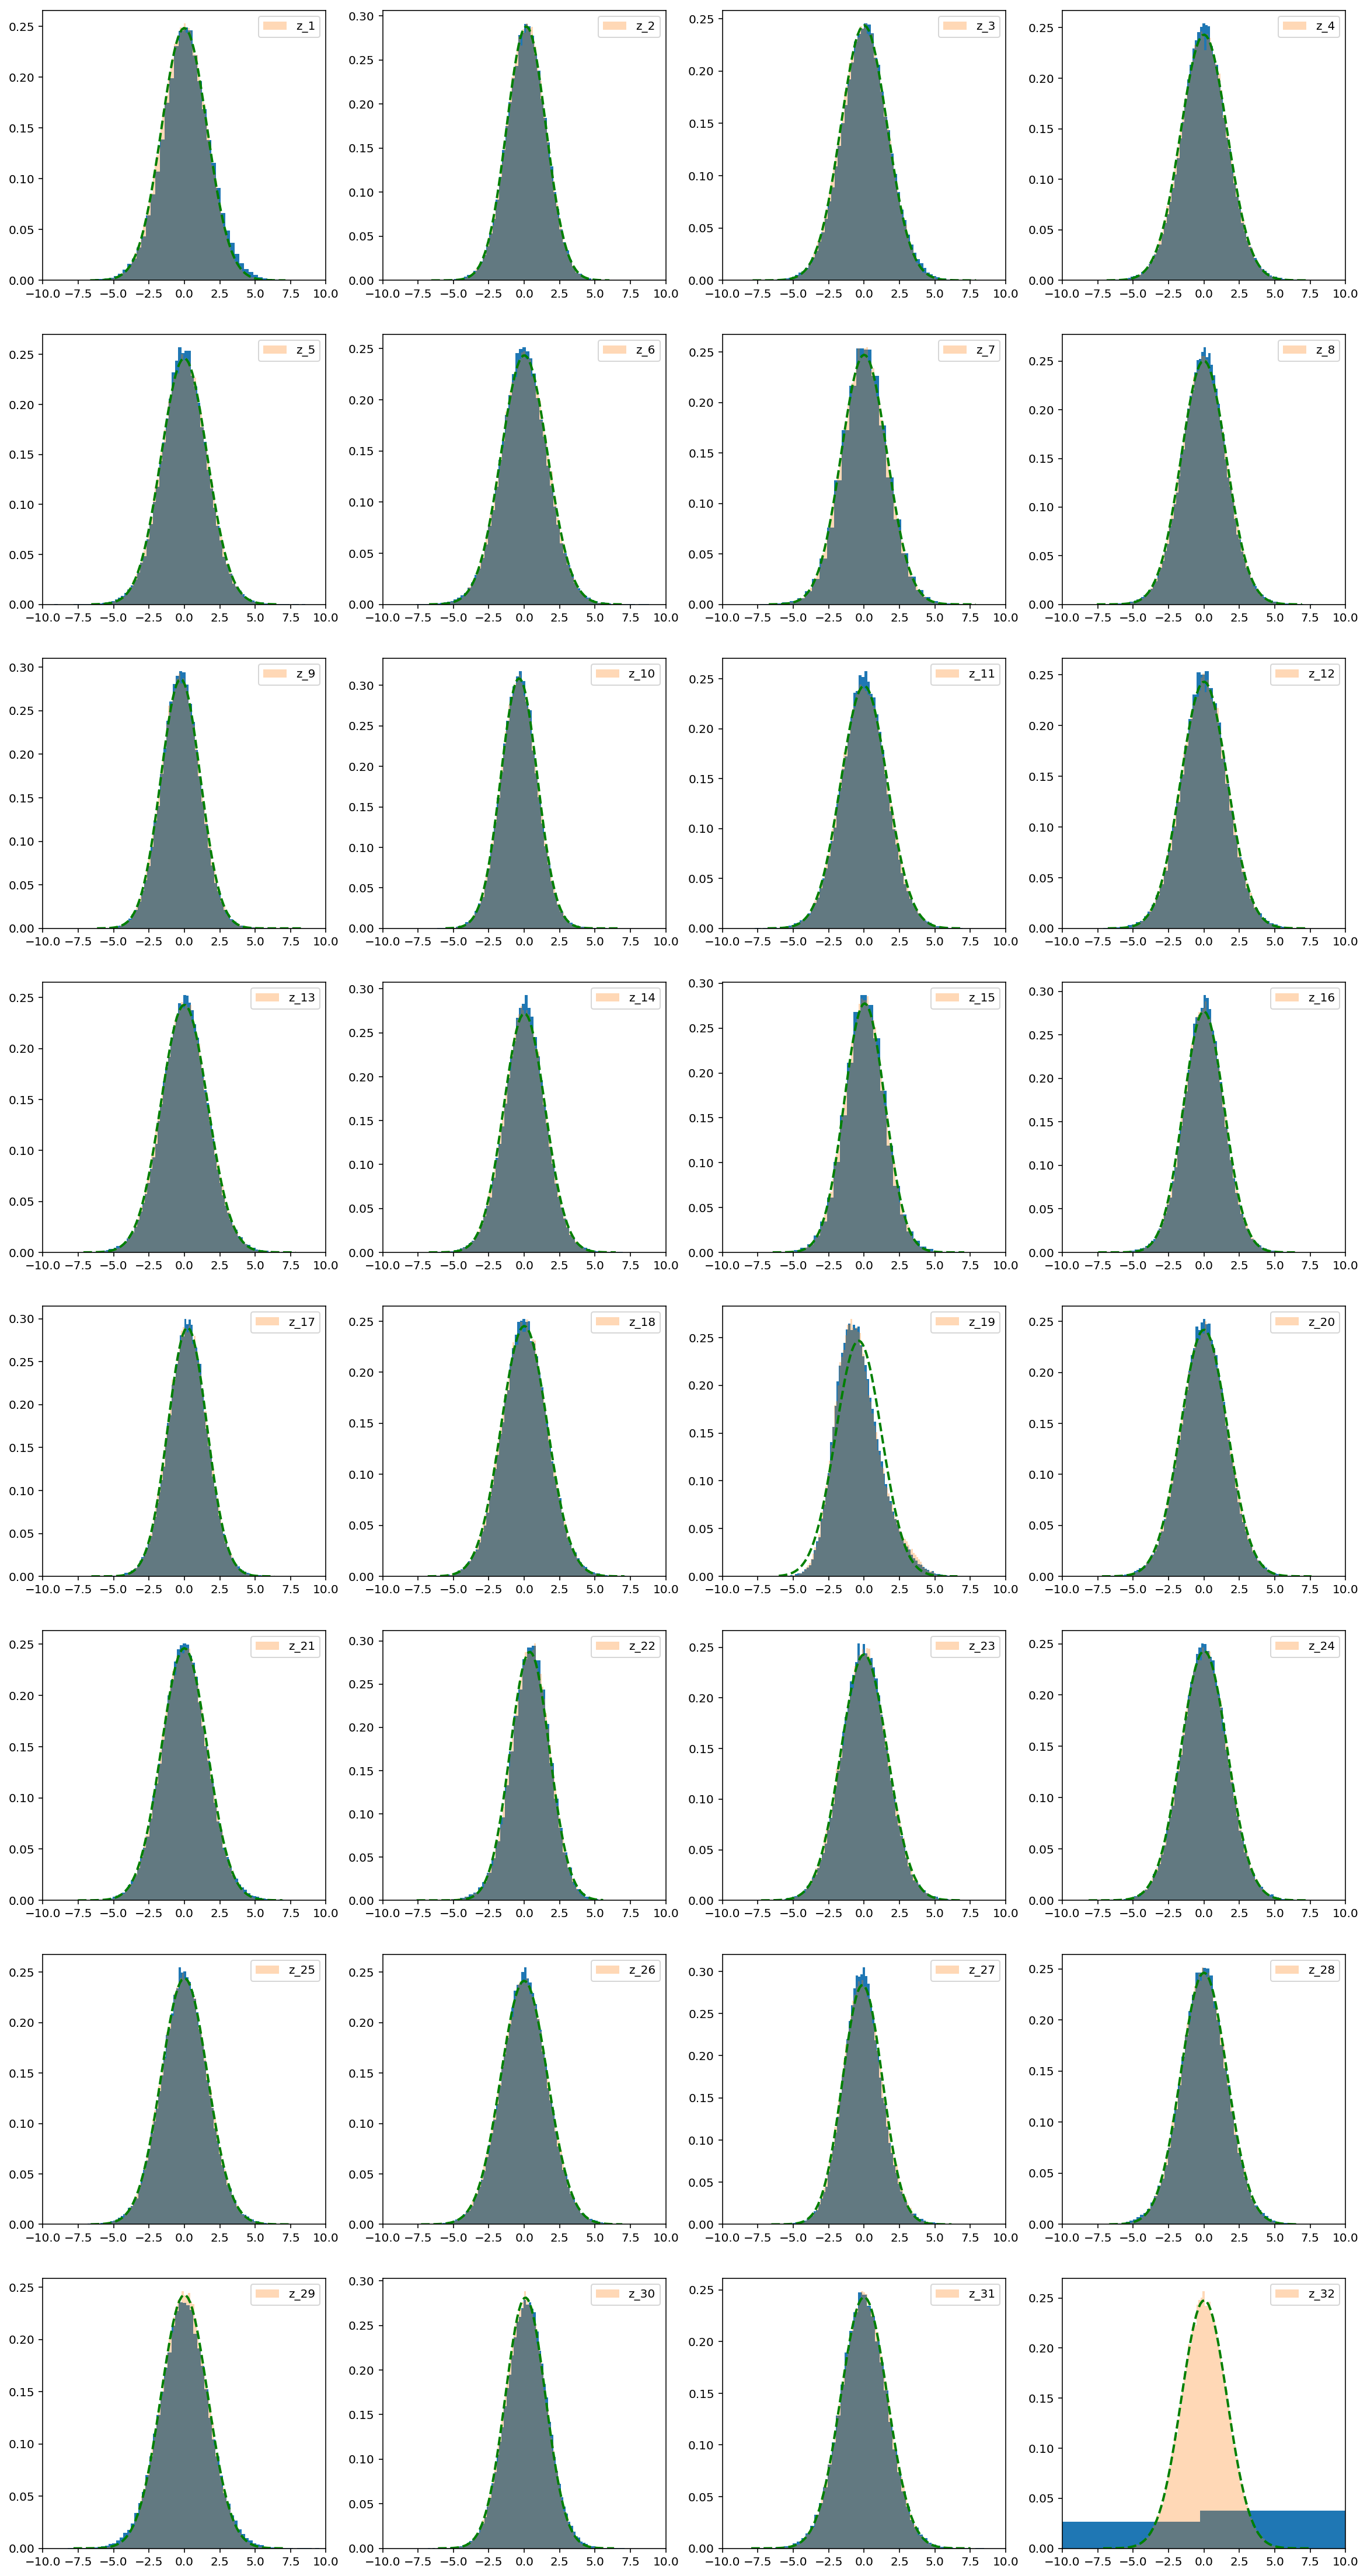

In [22]:
fig, axes = plt.subplots(8,4, figsize = (20,40))

for i in range (8):
    for j in range (4):
        print(i*4+j)
        #(mu, sigma) = norm.fit(samples[:,i*4+j])
        n, bins, patches = axes[i,j].hist(samples[:,i*4+j], density = True, bins = 100)
        #z_plt = mlab.normpdf( bins, mu, sigma)

        #axes[i,j].plot(bins, z_plt, 'r--', linewidth=2)
        #print('mu distrib transformed: '+str(mu)+' sigma distrib transformed: '+str(sigma))

        (mu, sigma) = norm.fit(z[:,i*4+j])
        n, bins, patches = axes[i,j].hist(z[:,i*4+j], density = True, bins = 100, alpha = 0.3, label = 'z_'+str(i*4+j+1))
        z_plt = mlab.normpdf( bins, mu, sigma)

        axes[i,j].plot(bins, z_plt, 'g--', linewidth=2)
        print('mu z: '+str(mu)+' sigma z: '+str(sigma))
        axes[i,j].legend()
        axes[i,j].set_xlim(-10,10)

## Test image generation

In [13]:
vae_lsst_conv,vae_lsst_utils, encoder_LSST, decoder_LSST, Dkl = utils.load_vae_full('../vae_weights/',6, folder= True)

W0119 14:09:18.250439 140027439593280 deprecation.py:506] From /sps/lsst/users/barcelin/miniconda/envs/python_cpu6/lib/python3.6/site-packages/tensorflow_core/python/ops/linalg/linear_operator_diag.py:166: calling LinearOperator.__init__ (from tensorflow.python.ops.linalg.linear_operator) with graph_parents is deprecated and will be removed in a future version.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
W0119 14:09:18.852967 140027439593280 util.py:148] Unused attribute in object (root): ['OBJECT_CONFIG_JSON']
W0119 14:09:18.853937 140027439593280 util.py:148] Unused attribute in object (root).layer-0: ['OBJECT_CONFIG_JSON']
W0119 14:09:18.854552 140027439593280 util.py:148] Unused attribute in object (root).layer_with_weights-0: ['OBJECT_CONFIG_JSON']
W0119 14:09:18.855124 140027439593280 util.py:148] Unused attribute in object (root).layer-2: ['OBJECT_CONFIG_JSON']
W0119 14:09:18.855608 140027439593280 util.py:148] Unused attribute in objec

../vae_weights/


In [16]:
samples = distribution.sample(100)

In [23]:
out = decoder_LSST(samples[:100])

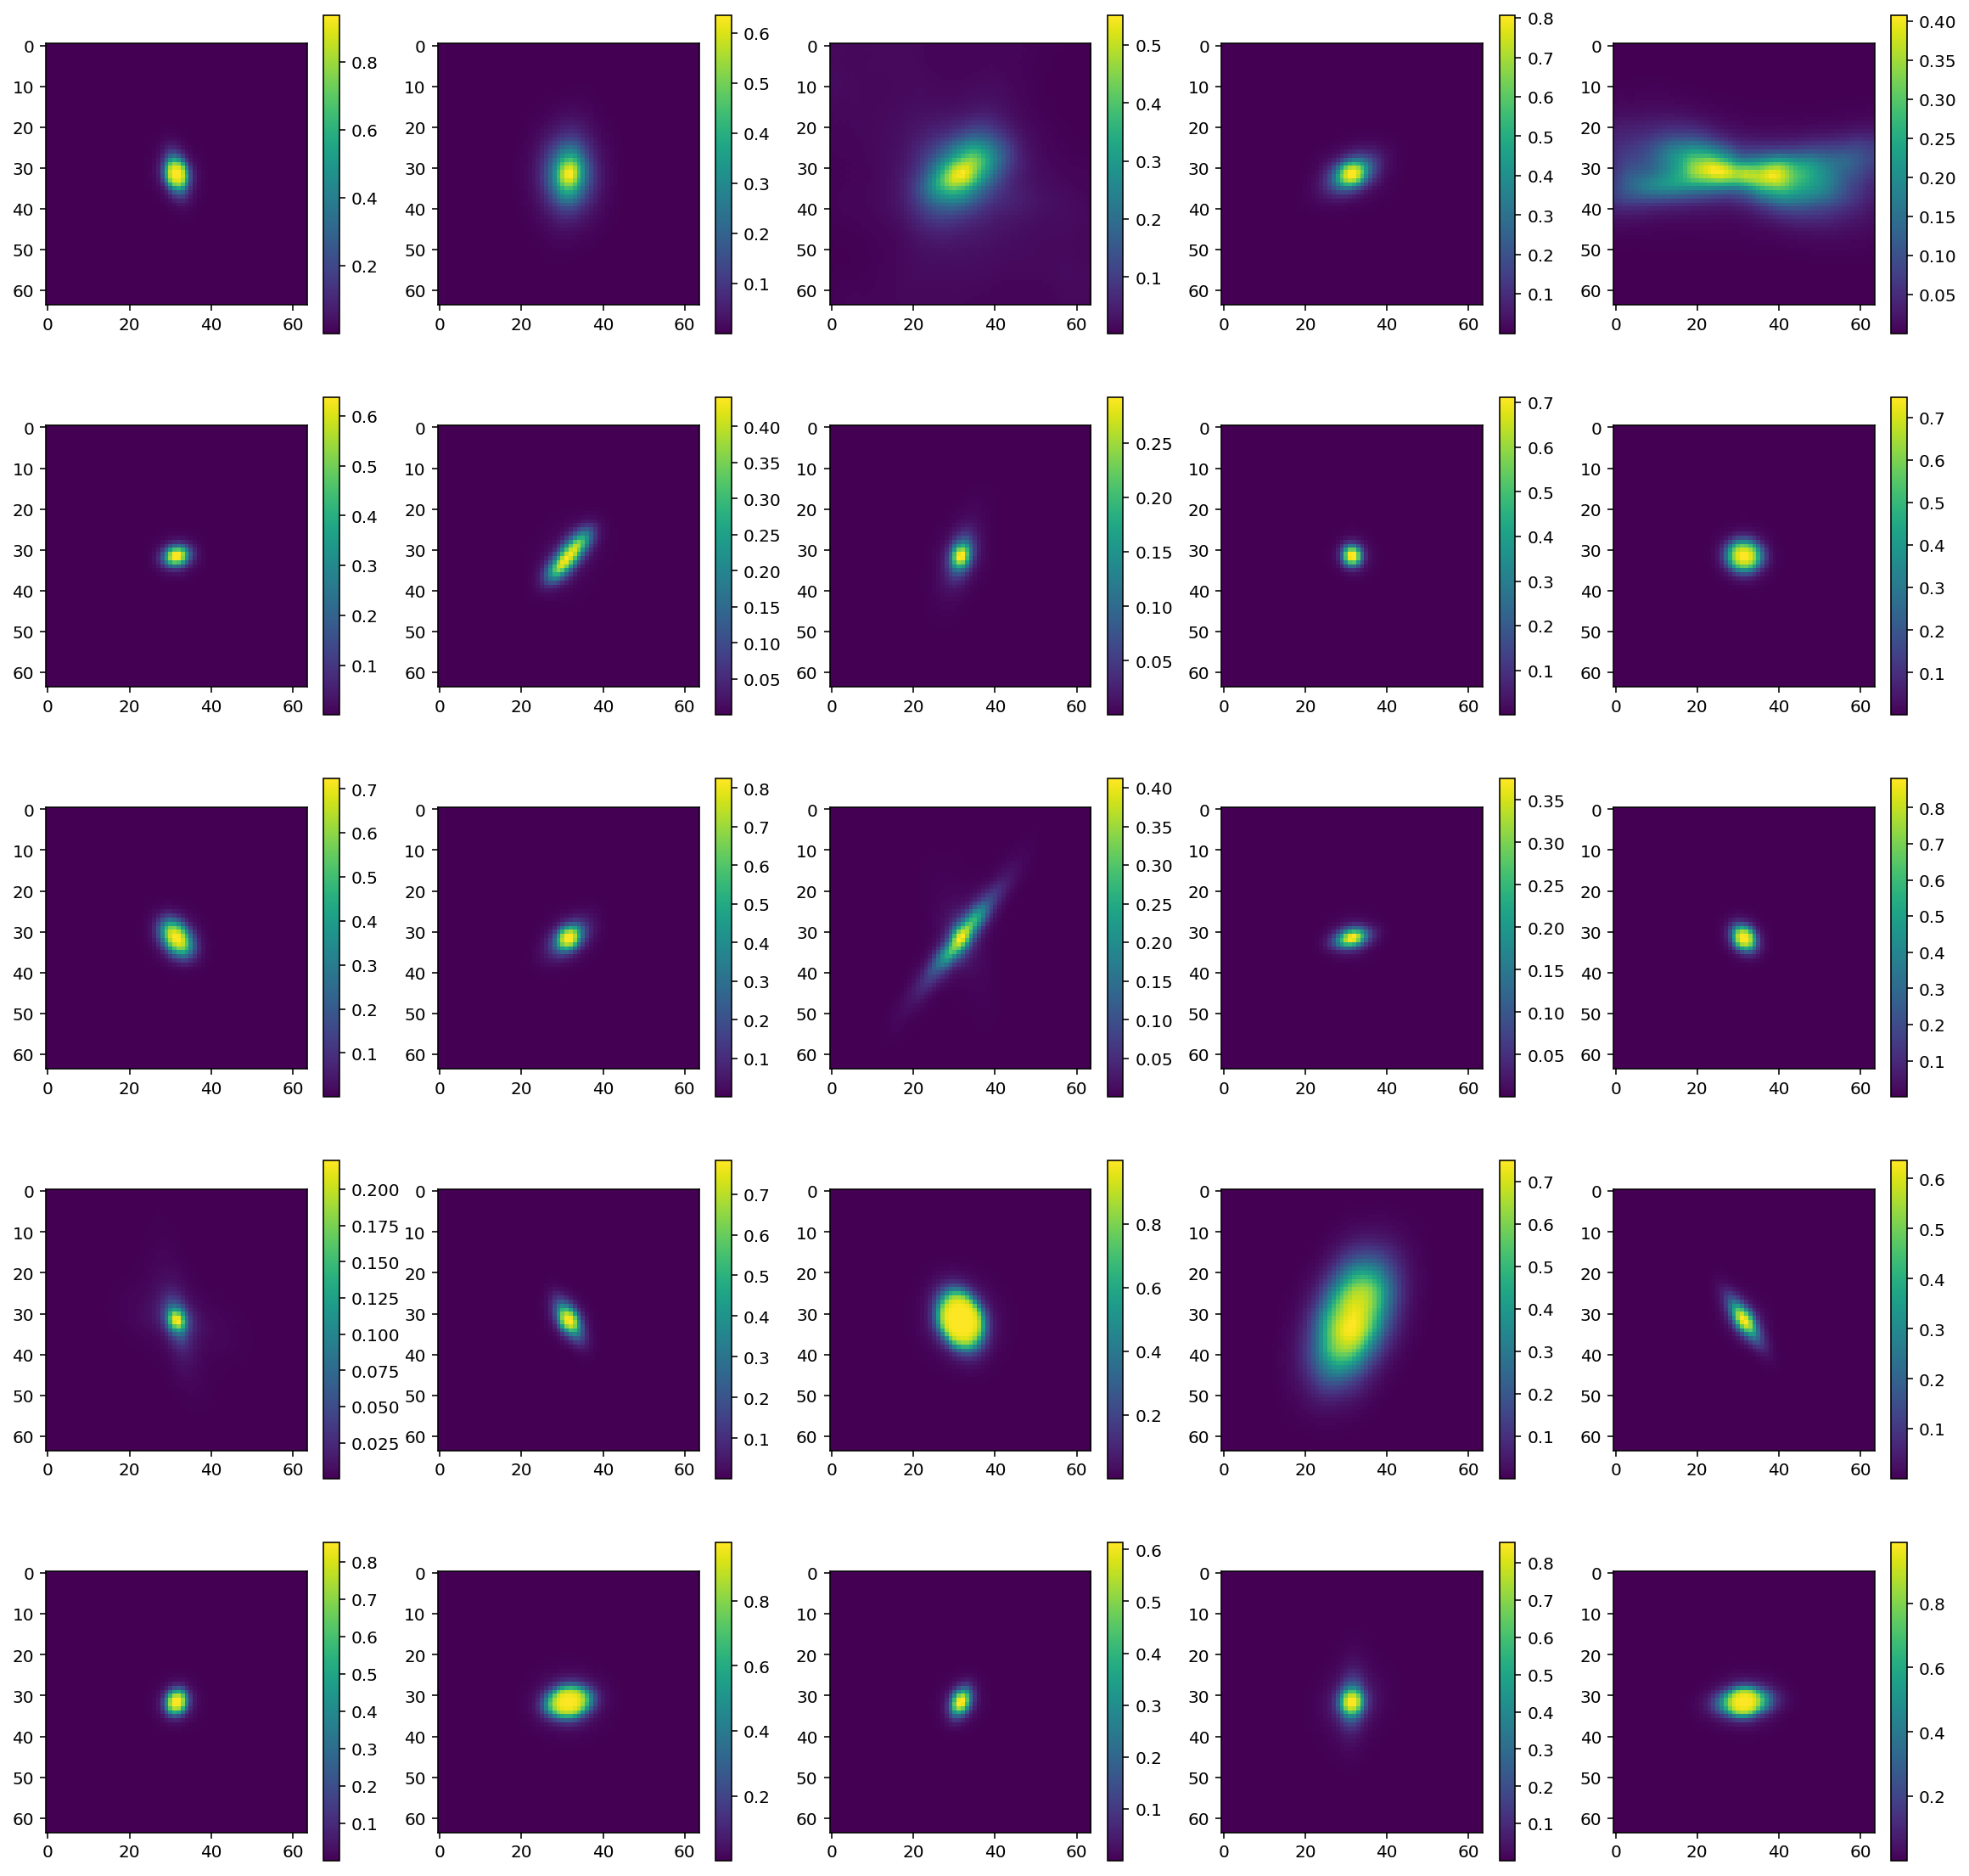

In [24]:
fig, axes = plt.subplots(5,5, figsize = (20,20))
for i in range (5):
    for j in range (5):
        fig_1 = axes[i,j].imshow(out[i*5+j,:,:,2])
        fig.colorbar(fig_1 ,ax=axes[i,j])

## Vizualisation of latent space sampling

code from https://www.machinecurve.com/index.php/2019/12/30/how-to-create-a-variational-autoencoder-with-keras/

In [25]:
img_width = 32
img_height = 32
num_channels = 6
def viz_decoded(decoder, n1, n2):
    num_samples = 15
    figure = np.zeros((img_width * num_samples, img_height * num_samples, num_channels))
    grid_x = np.linspace(-6, 6, num_samples)
    grid_y = np.linspace(-6, 6, num_samples)[::-1]
    z_sample = np.array([[np.mean(z[:,0]), np.mean(z[:,1]),np.mean(z[:,2]),np.mean(z[:,3]),np.mean(z[:,4]),np.mean(z[:,5]),np.mean(z[:,6]),np.mean(z[:,7]),np.mean(z[:,8])
                         ,np.mean(z[:,9]),np.mean(z[:,10]),np.mean(z[:,11]),np.mean(z[:,12]),np.mean(z[:,13]),np.mean(z[:,14]),np.mean(z[:,15]),np.mean(z[:,16])
                         ,np.mean(z[:,17]),np.mean(z[:,18]),np.mean(z[:,19]),np.mean(z[:,20]),np.mean(z[:,21]),np.mean(z[:,22]),np.mean(z[:,23]),np.mean(z[:,24])
                         ,np.mean(z[:,25]),np.mean(z[:,26]),np.mean(z[:,27]),np.mean(z[:,28]),np.mean(z[:,29]),np.mean(z[:,30]),np.mean(z[:,31])]])
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample[0,n1] = xi
            z_sample[0,n2] = yi
            x_decoded = decoder.predict(z_sample)
            #print(x_decoded[0].shape)
            digit = x_decoded[0].reshape(img_width*2, img_height*2, num_channels)
            figure[i * img_width: (i + 1) * img_width,
                  j * img_height: (j + 1) * img_height] = digit[16:48,16:48,:]
    plt.figure(figsize=(10, 10))
    start_range = img_width // 2
    end_range = num_samples * img_width + start_range + 1
    pixel_range = np.arange(start_range, end_range, img_width)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    # matplotlib.pyplot.imshow() needs a 2D array, or a 3D array with the third dimension being of shape 3 or 4!
    # So reshape if necessary
    fig_shape = np.shape(figure)
    if fig_shape[2] == 1:
        figure = figure.reshape((fig_shape[0], fig_shape[1]))
    # Show image
    plt.imshow(figure[:,:,2])
    plt.show()

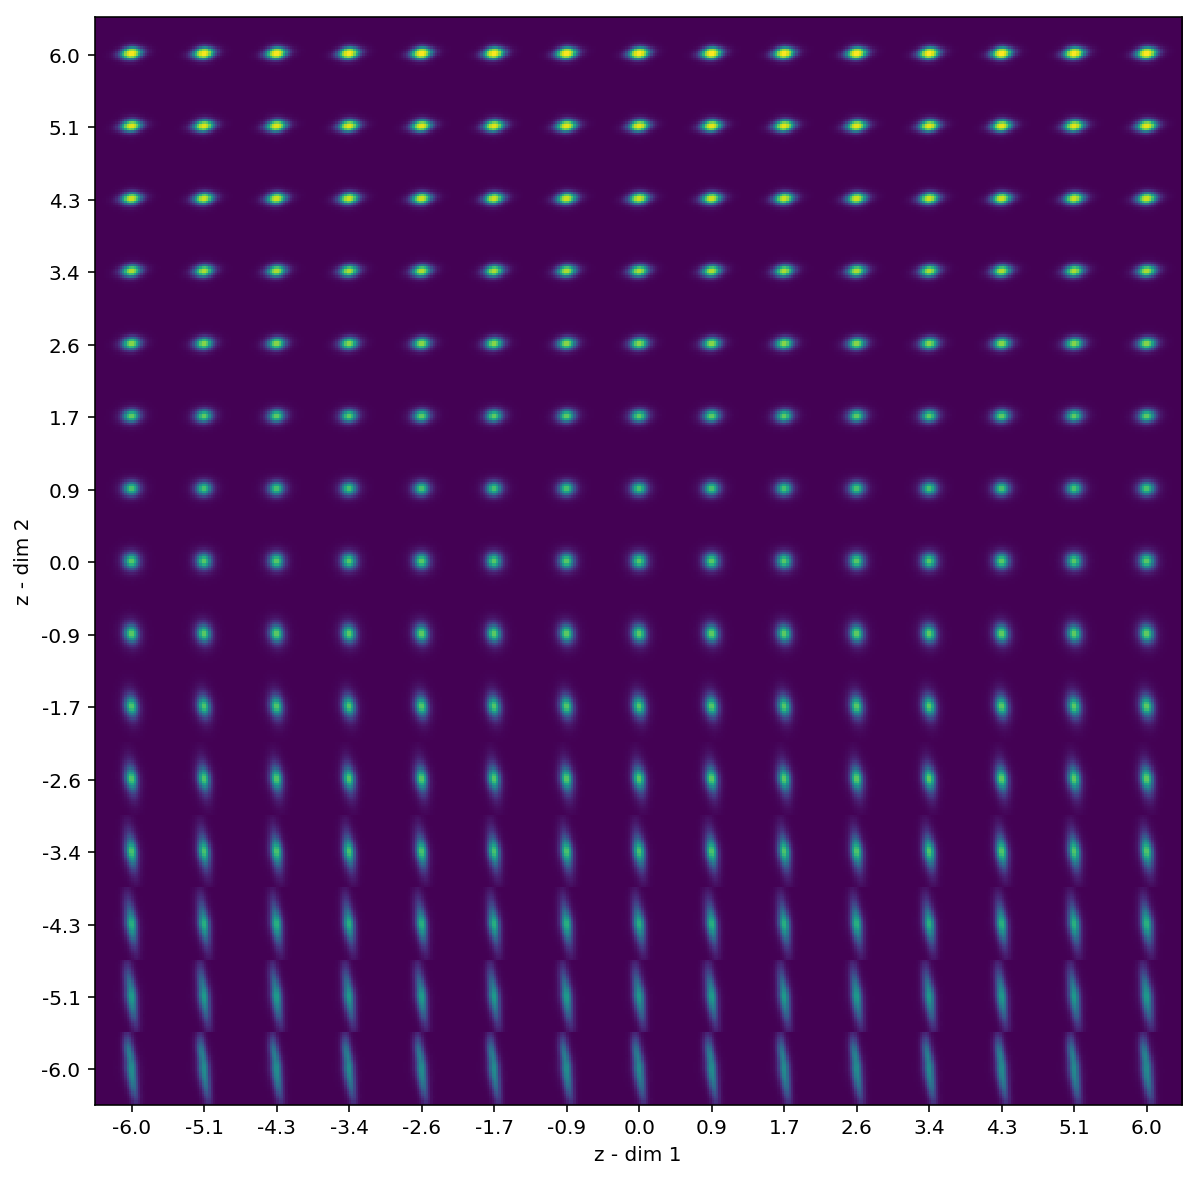

In [26]:
viz_decoded(decoder_LSST, 0, 1)

Check if according to results of normalizing flow, dimension 31 and 32 change something in shape of galaxy

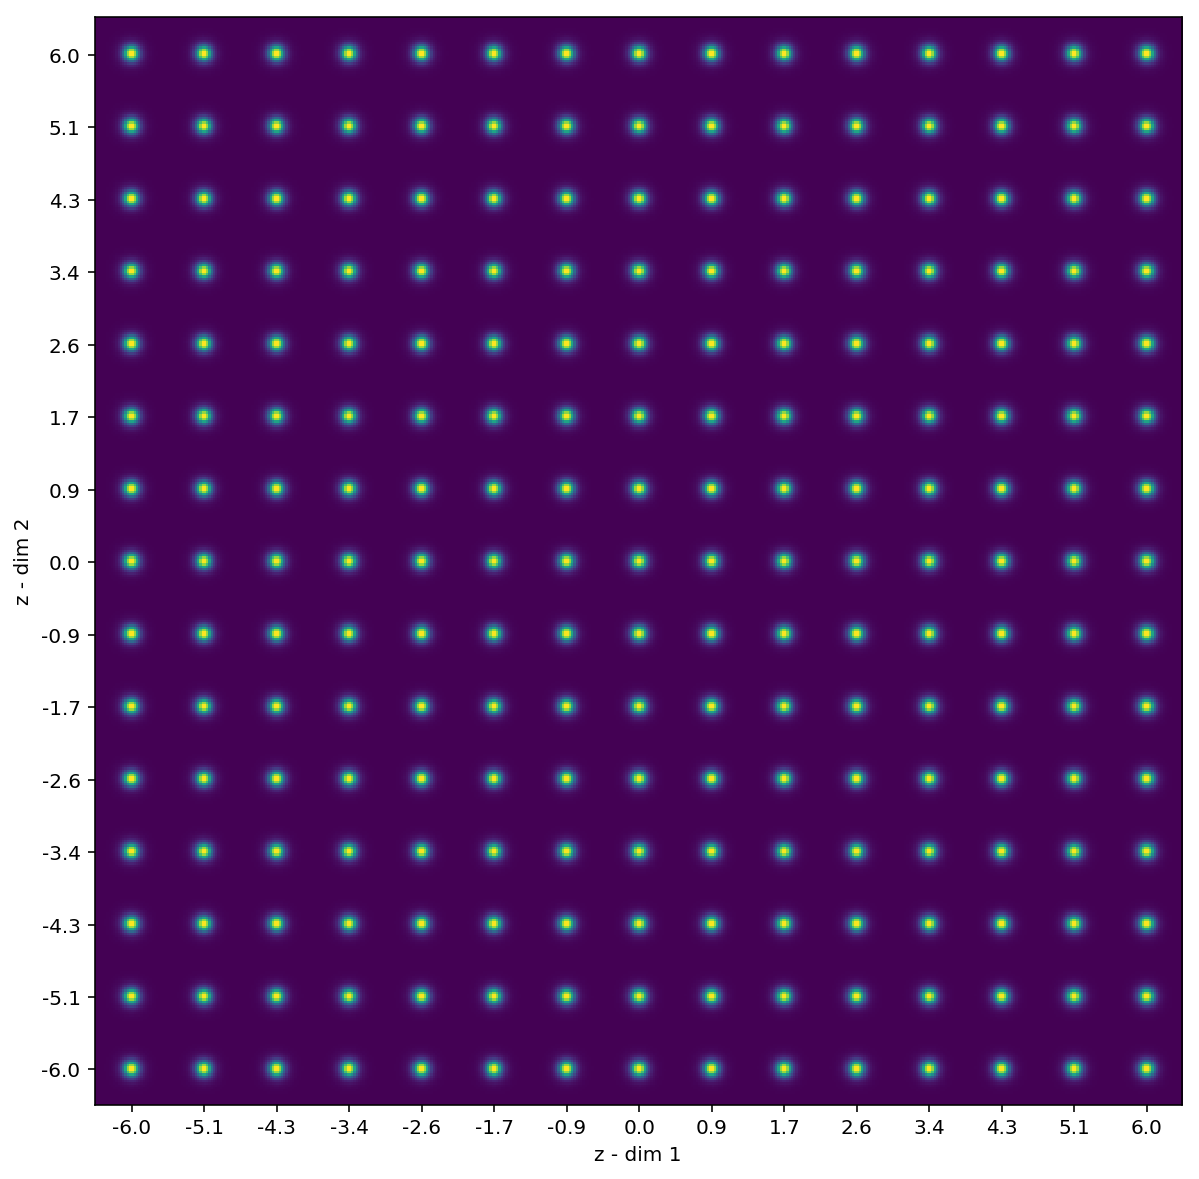

In [27]:
viz_decoded(decoder_LSST, 30, 31)

As expected with normalizing flow, no difference on latent space 31 and 32: helps to know if latent space dimension is useful or not. Check if also case for 26 and 31

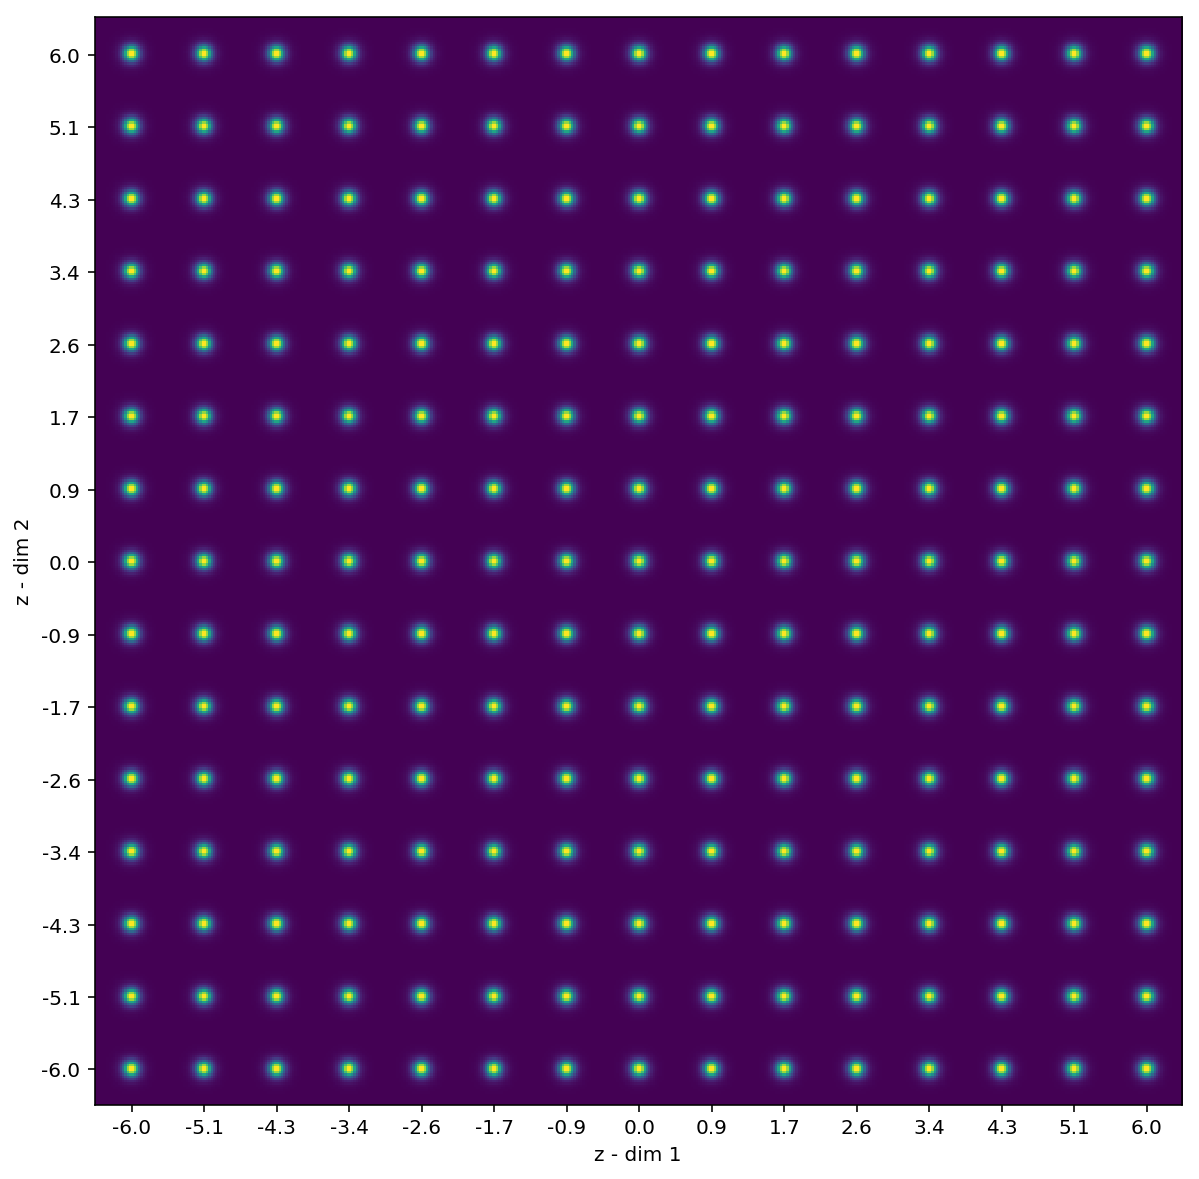

In [28]:
viz_decoded(decoder_LSST, 25, 30)

In [29]:
path = '../data/'
denorm = utils.denorm(np.array(out), bands = [0,1,2,3,4,5], path = path, channel_last=True)

print(np.array(out).shape)

bands=[1,2,3]
fig, axes = plt.subplots(1,2, figsize = (8,4))
gs1 = gridspec.GridSpec(1, 2)
gs1.update(wspace=0.05, hspace=0.05)

ax1 = plt.subplot(gs1[0])#axe[0]
ax1.imshow(np.clip(np.array(K.get_value(denorm[5]))[16:48,16:48,bands]/np.max(np.array(K.get_value(denorm[5]))[:,:,bands]), a_min=0.0, a_max=1.))
ax1.tick_params(axis='y', which='both',  left = False, labelleft=False)
ax1.tick_params(axis='x', which='both',bottom = False,labelbottom=False)
ax2 = plt.subplot(gs1[1])#axe[1]
ax2.imshow(np.clip(np.array(K.get_value(denorm[18]))[16:48,16:48,bands]/np.max(np.array(K.get_value(denorm[18]))[:,:,bands]), a_min=0.0, a_max=1.))
ax2.tick_params(axis='y', which='both',  left = False, labelleft=False)
ax2.tick_params(axis='x', which='both',bottom = False,labelbottom=False)
plt.savefig('../img/gal_vae.pdf', dpi = 300)

IndexError: tuple index out of range

## Image generation without normalizing flow

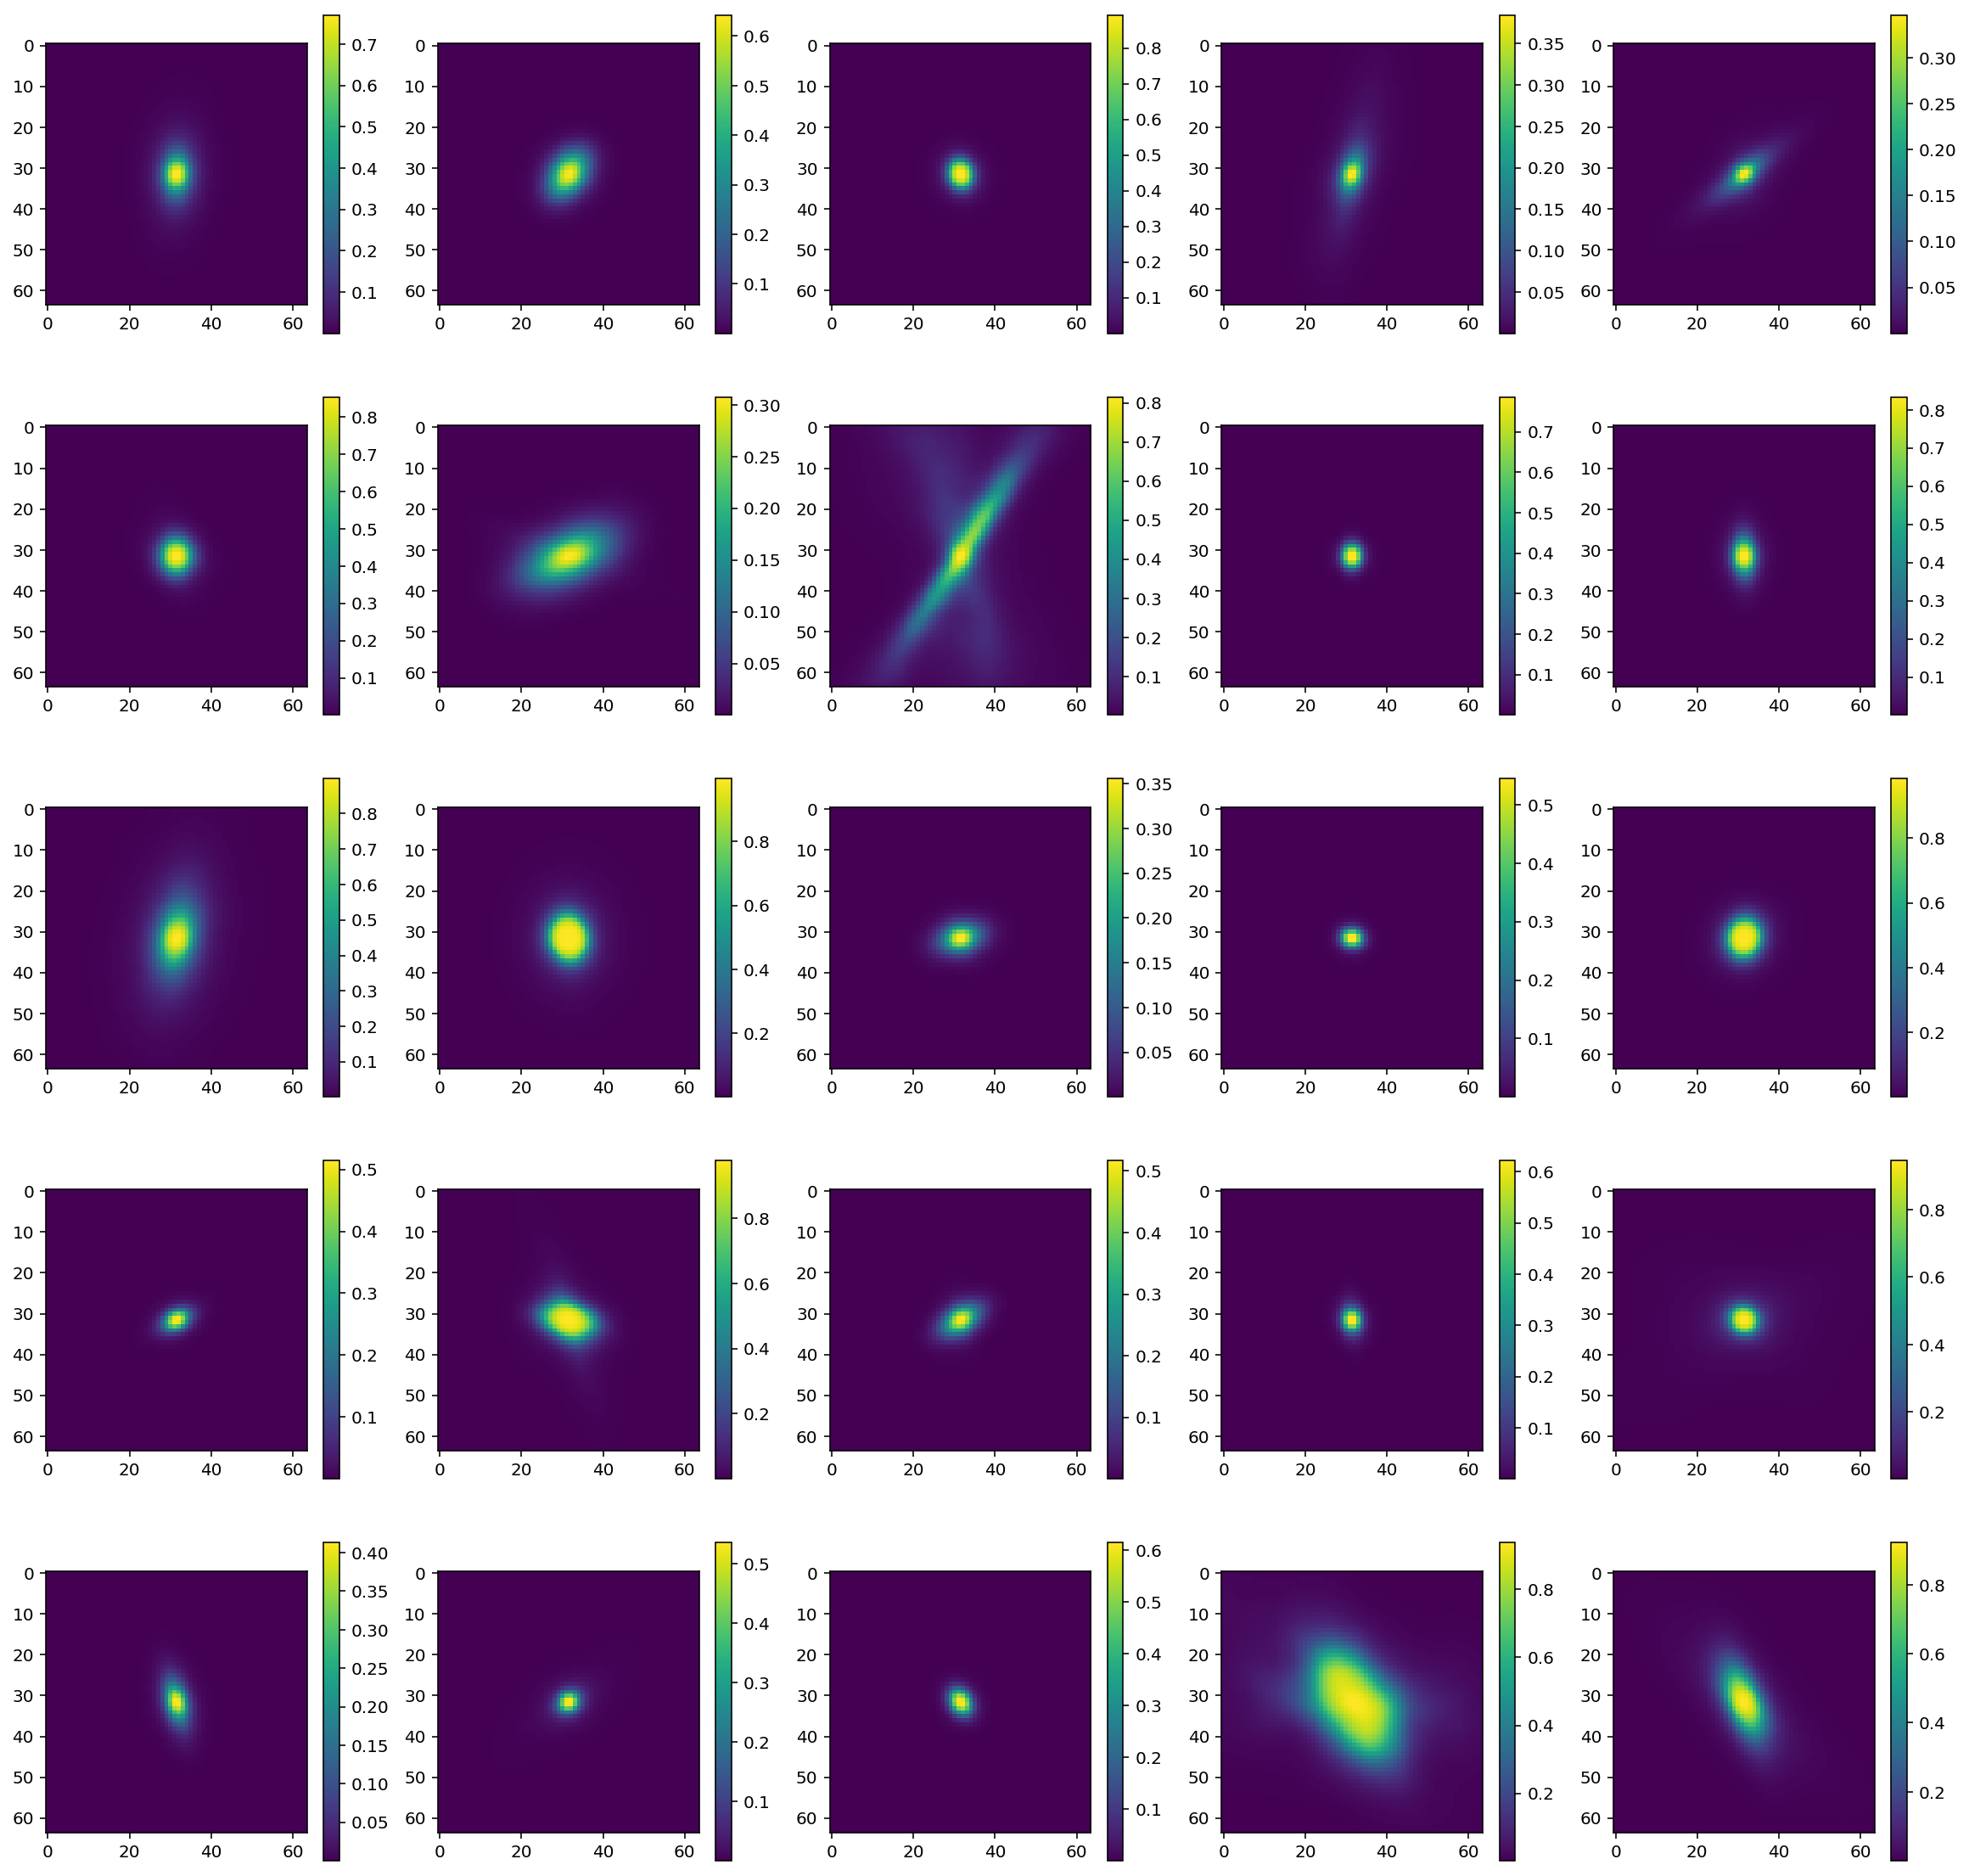

In [136]:
normal_sample = np.random.normal(loc=0.0, scale=1.0, size=(100,32))

out_no_transform = decoder_LSST(normal_sample)

fig, axes = plt.subplots(5,5, figsize = (20,20))
for i in range (5):
    for j in range (5):
        fig_1 = axes[i,j].imshow(out_no_transform[i*5+j,:,:,2])
        fig.colorbar(fig_1 ,ax=axes[i,j])